# Anime Recommendation System


#### Stavrinos Nikolaos 2631

#### Konstantinidis Konstantinos 2546

## Recommendation System

It is an unsupervised learning algorithm (one that lacks a target variable against which to measure accuracy) that is primarily used to aid in consumer decision making. They also appear in places such as streaming apps (such as Netflix and Hulu) to help you choose a TV show or movie to watch next, and on journalism/media websites such as Medium to suggest other articles you might be interested in reading, among many other applications. Many e-commerce sites, such as Amazon, have obviously been using recommender algorithms for quite some time, but many smaller or newer sites are still in need. There are various types of recommenders, each of which bases its predictions on a different set of criteria.

## Import libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

#Visualization Phase
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
pd.set_option('display.max_columns', 500)
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Dataset Details

This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

### 1)anime_data:

* **anime_id** - myanimelist.net's unique id identifying an anime.
* **name** - full name of anime.
* **genre** - comma separated list of genres for this anime.
* **type** - movie, TV, OVA, etc.
* **episodes** - how many episodes in this show. (1 if movie).
* **rating** - average rating out of 10 for this anime.
* **members** - number of community members that are in this anime's "group".

### 2)rating_data:

* **user_id** - non identifiable randomly generated user id.
* **anime_id** - the anime that this user has rated.
* **rating** - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

# Read the data

In [2]:
anime_data = pd.read_csv("anime.csv")
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
anime_data.shape

(12294, 7)

In [4]:
anime_data.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [5]:
rating_data=pd.read_csv('https://github.com/vineethvs23/Anime-Recommendation/raw/master/rating.csv')
rating_data.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
rating_data.shape

(7813737, 3)

In [7]:
rating_data.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64


## Cleaning anime_title

#### We got many symbols found in anime_title. Removing those using this function

In [8]:
import re
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_data['name'] = anime_data['name'].apply(text_cleaning)

# Handling Missing Value

## Handling missing rating

In [9]:
anime_data.loc[anime_data['rating'].isnull(), 'rating'] = 0.0
anime_data['rating'].isnull().any()

False

## Handling missing type

#### Our approach is to fill the missing type based on the number of the episodes. But after checking the data, some of the anime have 'unknown' episodes and missing type.

In [10]:
anime_data.loc[(anime_data['episodes']=="Unknown") & (anime_data['type'].isnull())].head()

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666


In [11]:
missing = anime_data.loc[(anime_data['episodes']=="Unknown") & (anime_data['type'].isnull())].copy()
missing.shape

(25, 7)

In [12]:
missing.head(25)

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666
10949,33475,Busou Shoujo Machiavellianism,"Action, School, Shounen",NaN,Unknown,0.0,1896
10963,31456,Code:Realize: Sousei no Himegimi,"Adventure, Fantasy, Romance, Shoujo",NaN,Unknown,0.0,4017
10983,34332,Flying Babies,NaN,NaN,Unknown,0.0,22
10988,34280,Gamers!,"Comedy, Romance, School",NaN,Unknown,0.0,1045
10990,34485,Ganko-chan,NaN,NaN,Unknown,0.0,11


It seems the data is not up to date with the current season. There is no other way, We have to manually fill the type and the episodes.

## Manually filling the type and the episodes

In [13]:
anime_data.loc[(anime_data['name'] == "Steins;Gate 0"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Steins;Gate 0"), 'episodes'] = '23'
anime_data.loc[(anime_data['name'] == "Violet Evergarden"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Violet Evergarden"), 'episodes'] = '13'
anime_data.loc[(anime_data['name'] == "Code Geass: Fukkatsu no Lelouch"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Code Geass: Fukkatsu no Lelouch"), 'episodes'] = '25'
anime_data.loc[(anime_data['name'] == "K: Seven Stories"), 'type'] = 'Movie'
anime_data.loc[(anime_data['name'] == "K: Seven Stories"), 'episodes'] = '6'
anime_data.loc[(anime_data['name'] == "Free! (Shinsaku)"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Free! (Shinsaku)"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Busou Shoujo Machiavellianism"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Busou Shoujo Machiavellianism"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Code:Realize: Sousei no Himegimi"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Code:Realize: Sousei no Himegimi"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Gamers!"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Gamers!"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Ganko-chan"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Ganko-chan"), 'episodes'] = '10'
anime_data.loc[(anime_data['name'] == "Ginga Eiyuu Densetsu (2017)"), 'type'] = 'OVA'
anime_data.loc[(anime_data['name'] == "Ginga Eiyuu Densetsu (2017)"), 'episodes'] = '110'
anime_data.loc[(anime_data['name'] == "Grancrest Senki"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Grancrest Senki"), 'episodes'] = '24'
anime_data.loc[(anime_data['name'] == "IDOLiSH7"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "IDOLiSH7"), 'episodes'] = '17'
anime_data.loc[(anime_data['name'] == "Isekai Shokudou"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Isekai Shokudou"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Oushitsu Kyoushi Haine"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Oushitsu Kyoushi Haine"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Peace Maker Kurogane (Shinsaku)"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Peace Maker Kurogane (Shinsaku)"), 'episodes'] = '24'
anime_data.loc[(anime_data['name'] == "Seikaisuru Kado"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Seikaisuru Kado"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "UQ Holder!"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "UQ Holder!"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Citrus"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Citrus"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Hitorijime My Hero"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Hitorijime My Hero"), 'episodes'] = '12'
anime_data.loc[(anime_data['name'] == "Flying Babies"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Gekidol"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Ginga Jinpuu Jinraiger"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Mirai Arise"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Project758"), 'type'] = 'TV'
anime_data.loc[(anime_data['name'] == "Rescue Academia"), 'type'] = 'TV'
anime_data.isnull().sum()

anime_id     0
name         0
genre       62
type         0
episodes     0
rating       0
members      0
dtype: int64

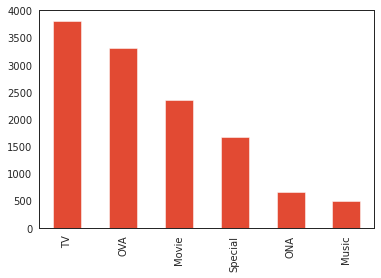

In [14]:
anime_data['type'].value_counts().plot.bar()

## Handling Unknown Genre

In [15]:
anime_data.isnull().sum()

anime_id     0
name         0
genre       62
type         0
episodes     0
rating       0
members      0
dtype: int64

In [16]:
anime_data[anime_data['genre'].isnull()]

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
11070,32032,Seikaisuru Kado,NaN,TV,12,0.00,1797
11086,34310,Tamagotchi Movie: Tanpen Himitsu no Otodoke Da...,NaN,Movie,1,0.00,51
11097,34474,Tsukipro The Animation,NaN,TV,Unknown,0.00,843
11112,33035,Yuyushiki Special,NaN,Special,1,0.00,2294


#### Fill NaN values with 'Unknown'.

In [17]:
anime_data['genre'].fillna('Unknown', inplace=True)
anime_data.isnull().any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

In [18]:
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


## Merging dataframes 

#### In this section we are fusing our csv files 

In [19]:
anime_fulldata=pd.merge(anime_data,rating_data,on='anime_id',suffixes= ['', '_user'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


# Analyze the data


#### Inorder to build a recommendation engine, we have to understand our dataset. So, let's see an overview of the dataset.

## Top 10 Anime based on rating counts

Text(0, 0.5, 'User Rating count')

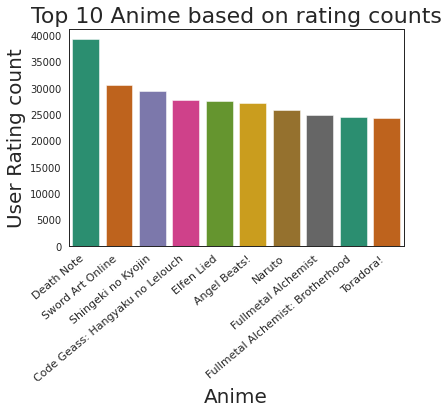

In [20]:
# Creating a dataframe for rating counts
combine_anime_rating = anime_fulldata.dropna(axis = 0, subset = ['anime_title'])
anime_ratingCount = (combine_anime_rating.
     groupby(by = ['anime_title'])['user_rating'].
     count().
     reset_index().rename(columns = {'rating': 'totalRatingCount'})
    [['anime_title', 'user_rating']]
    )


top10_animerating=anime_ratingCount[['anime_title', 'user_rating']].sort_values(by = 'user_rating',ascending = False).head(10)
ax=sns.barplot(x="anime_title", y="user_rating", data=top10_animerating, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

**Results:** <br>
* Death Note comes in first for rating count followed by sword art online and Attack on Titan

In [21]:
anime_fulldata = anime_fulldata.merge(anime_ratingCount, left_on = 'anime_title', right_on = 'anime_title', how = 'left')
anime_fulldata = anime_fulldata.rename(columns={'user_rating_x': 'user_rating', 'user_rating_y': 'totalratingcount'})

In [22]:
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating,totalratingcount
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,2199
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,2199
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,2199
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,2199
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1,2199


## Top 10 Anime based on Community size

In [23]:
duplicate_anime=anime_fulldata.copy()
duplicate_anime.drop_duplicates(subset ="anime_title", 
                     keep = 'first', inplace = True)

Text(0, 0.5, 'Community Size')

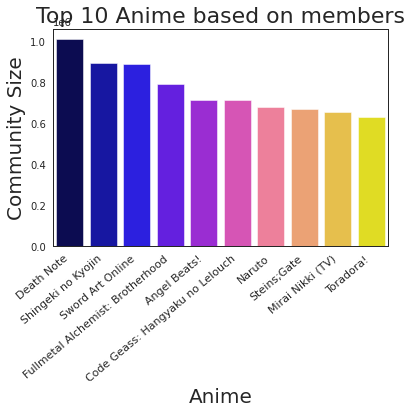

In [24]:
top10_animemembers=duplicate_anime[['anime_title', 'members']].sort_values(by = 'members',ascending = False).head(10)
ax=sns.barplot(x="anime_title", y="members", data=top10_animemembers, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('Community Size', fontsize = 20)

**Results:** <br>
* Death Note comes in first for community size followed by Attack on Titan and sword art online 

## Distribution of ratings
#### We'll be now sensing the distribution of ratings on both the datasets. The rating from anime.csv is from review websites and user_rating in rating.csv is from user id's

Text(0.5, 1.0, 'Rating of users')

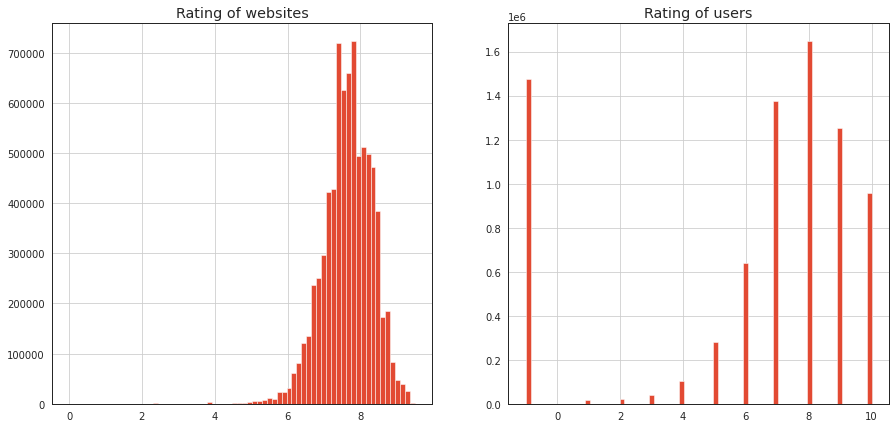

In [25]:
plt.figure(figsize = (15, 7))
plt.subplot(1,2,1)
anime_fulldata['rating'].hist(bins=70)
plt.title("Rating of websites")
plt.subplot(1,2,2)
anime_fulldata['user_rating'].hist(bins=70)
plt.title("Rating of users")

**Insights:**
* Most of the ratings are spread between 6-10
* The mode of the distribution is around 7.5-8.0
* Both the distribution are left skewed
* We have -1 rating as an outlier in rating of users which can be made into NaN

## Medium of streaming 

In [26]:
import plotly.graph_objects as go
labels = anime_fulldata['type'].value_counts().index
values = anime_fulldata['type'].value_counts().values
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Medium of Streaming",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

**Insights:**
* 67.6% of the anime's were aired on TV followed by 13.5% through Movie
* 10.2% of anime's are streamed as OVA which is greater than ONA(1.18%)

## Genre Word Cloud
#### Visualization of the most common genre

(-0.5, 799.5, 399.5, -0.5)

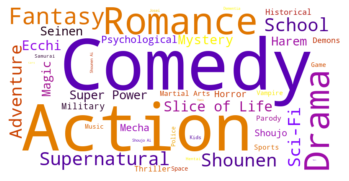

In [27]:
nonull_anime=anime_fulldata.copy()
nonull_anime.dropna(inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1
        
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

# Preparing data for consumption

#### Before giving our data to the recommendation engine we have to fine tune them

### a) Handling NaN values

#### First we have to take care of the NaN values, as this revolves around ratings, a user who hasn't given any ratings has added no value to the engine. 

In [28]:
anime_feature=anime_fulldata.copy()
anime_feature["user_rating"].replace({-1: np.nan}, inplace=True)
anime_feature.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating,totalratingcount
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0,2199
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0,2199
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0,2199
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0,2199
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,NaN,2199


In [29]:
anime_feature = anime_feature.dropna(axis = 0, how ='any') 
anime_feature.isnull().sum()

anime_id            0
anime_title         0
genre               0
type                0
episodes            0
rating              0
members             0
user_id             0
user_rating         0
totalratingcount    0
dtype: int64

### b) Filtering user_id

#### Let's check out the counts of user id and filter based on it

In [30]:
anime_feature['user_id'].value_counts()

42635    3747
53698    2905
57620    2689
59643    2632
51693    2621
         ... 
4507        1
67112       1
51639       1
50718       1
30683       1
Name: user_id, Length: 69600, dtype: int64

### Finding the mean of rated anime by each user

In [31]:
anime_feature['user_id'].value_counts().mean()

91.05228448275862

#### There are users who has rated only once, even if they have rated it 5, it can't be considered a valuable record for recommendation. So we have considered minimum 300 ratings by the user as threshold value. You can play around changing the threshold value to get better results, but this worked fine.

#### In a case where our computational system would be capable enough to handle our load, we would choose set the threshold at 91 ratings per user, because of our mean of ratings. 

In [32]:
counts = anime_feature['user_id'].value_counts()
anime_feature = anime_feature[anime_feature['user_id'].isin(counts[counts >= 300].index)]

## Types of Recommendation Systems
<img src="https://miro.medium.com/max/4056/1*yrkvweErbifbPFkBUyZlOw.png">

## Content based filtering



#### Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document.A content based recommender works with data that the user provides, either explicitly (rating) or implicitly (clicking on a link). Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.


# Recommendation building phase

This function is beeing use to make recommendations based on genre and type of medium.
You can choose to prioritize similarity or rating values on your recommendation functions.


In [33]:
indices = pd.Series(anime_data.index, index=anime_data['name'])

def genre_recommendations(title, highest_rating=False, similarity=False):
    
    if highest_rating == False:
        if similarity == False:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
        
            return pd.DataFrame({'Anime name': anime_data['name'].iloc[anime_indices].values,
                                 'Type': anime_data['type'].iloc[anime_indices].values})
    
        elif similarity == True:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
            similarity_ = [i[1] for i in sim_scores]
        
            return pd.DataFrame({'Anime name': anime_data['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_data['type'].iloc[anime_indices].values})
        
    elif highest_rating == True:
        if similarity == False:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
        
            result_df = pd.DataFrame({'Anime name': anime_data['name'].iloc[anime_indices].values,
                                 'Type': anime_data['type'].iloc[anime_indices].values,
                                 'Rating': anime_data['rating'].iloc[anime_indices].values})
            
            return result_df.sort_values('Rating', ascending=False)

        elif similarity == True:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
            similarity_ = [i[1] for i in sim_scores]
        
            result_df = pd.DataFrame({'Anime name': anime_data['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_data['type'].iloc[anime_indices].values,
                                 'Rating': anime_data['rating'].iloc[anime_indices].values})
            
            return result_df.sort_values('Rating', ascending=False) 

### Term Frequency (TF) and Inverse Document Frequency (IDF)



TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “the rise of analytics” on Google. It is certain that “the” will occur more frequently than “analytics” but the relative importance of analytics is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

### We want our algorithm to treat the 'type' and 'genre' of anime as equal. 

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer


genres_str = anime_data['genre'].str.split(',').astype(str)

for i in range(0,len(genres_str)):
    genres_str.at[i]=str(genres_str[i][:len(genres_str[i])-1])+","+" '"+ str(anime_data.loc[i,'type'])+"']"
   
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 4), min_df=0)
tfidf_matrix = tfidf.fit_transform(genres_str)


## Linear Kernel Recommendation

The function linear_kernel computes the linear kernel, that is, a special case of polynomial_kernel with degree=1 and coef0=0 (homogeneous). If x and y are column vectors, their linear kernel is:

$k(x, y) = x^\top y$

In [35]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
pd.DataFrame(cosine_sim)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,12044,12045,12046,12047,12048,12049,12050,12051,12052,12053,12054,12055,12056,12057,12058,12059,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,12100,12101,12102,12103,12104,12105,12106,12107,12108,12109,12110,12111,12112,12113,12114,12115,12116,12117,12118,12119,12120,12121,12122,12123,12124,12125,12126,12127,12128,12129,12130,12131,12132,12133,12134,12135,12136,12137,12138,12139,12140,12141,12142,12143,12144,12145,12146,12147,12148,12149,12150,12151,12152,12153,12154,12155,12156,12157,12158,12159,12160,12161,12162,12163,12164,12165,12166,12167,12168,12169,12170,12171,12172,12173,12174,12175,12176,12177,12178,12179,12180,12181,12182,12183,12184,12185,12186,12187,12188,12189,12190,12191,12192,12193,12194,12195,12196,12197,12198,12199,12200,12201,12202,12203,12204,12205,12206,12207,12208,12209,12210,12211,12212,12213,12214,12215,12216,12217,12218,12219,12220,12221,12222,12223,12224,12225,12226,12227,12228,12229,12230,12231,12232,12233,12234,12235,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245,12246,12247,12248,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274,12275,12276,12277,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287,12288,12289,12290,12291,12292,12293
0,1.000000,0.011186,0.000000,0.000000,0.000000,0.035866,0.000000,0.016362,0.009765,0.000000,0.047303,0.061901,0.000000,0.012277,0.035866,0.121834,0.086023,0.015808,0.017817,0.014978,0.017456,0.022507,0.013484,0.015365,0.020452,0.125997,0.034004,0.015808,0.015808,0.000000,0.032248,0.032112,0.017456,0.061532,0.032112,0.051709,0.021797,0.033820,0.009448,0.094571,0.018275,0.000000,0.024954,0.035866,0.017456,0.051770,0.032112,0.000000,0.015487,0.022149,0.020796,0.000000,0.019778,0.013305,0.013460,0.010794,0.032112,0.042686,0.025904,0.016010,0.173767,0.026945,0.000000,0.009765,0.036283,0.009765,0.016092,0.011155,0.015815,0.000000,0.147903,0.057736,0.025904,0.082780,0.012448,0.000000,0.034843,0.044219,0.000000,0.035866,0.000000,0.051829,0.021934,0.026053,0.017652,0.015487,0.013751,0.094571,0.198495,0.071600,0.019054,0.029967,0.014315,0.010423,0.029993,0.020496,0.013238,0.027459,0.000000,0.000000,0.025904,0.000000,0.025369,0.018312,0.000000,0.026945,0.014358,0.025369,0.018556,0.015606,0.028479,0.027387,0.000000,0.025422,0.075175,0.112689,0.000000,0.028682,0.017515,0.015204,0.013996,0.000000,0.025904,0.023639,0.020278,0.023125,0.000000,0.022380,0.029707,0.040960,0.022653,0.084216,0.096274,0.028646,0.029217,0.014282,0.012822,0.013571,0.022380,0.017456,0.000000,0.018873,0.032112,0.027652,0.021677,0.000000,0.000000,0.015837,0.017456,0.000000,0.011650,0.032474,0.024376,0.021343,0.013841,0.031037,0.031269,0.032536,0.206939,0.123008,0.039222,0.029412,0.000000,0.027652,0.075401,0.013944,0.028853,0.016847,0.069101,0.000000,0.031958,0.000000,0.037317,0.028831,0.026009,0.000000,0.018332,0.020278,0

In [36]:
genre_recommendations('Naruto: Shippuuden', highest_rating=False, similarity=True)

,Anime name,Similarity,Type
0,Naruto,1.000000,TV
1,Boruto: Naruto the Movie,0.854500,Movie
2,Naruto: Shippuuden Movie 4 - The Lost Tower,0.854500,Movie
3,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0.854500,Movie
4,Naruto Soyokazeden Movie: Naruto to Mashin to ...,0.854500,Movie
5,Naruto x UT,0.853885,OVA
6,Boruto: Naruto the Movie - Naruto ga Hokage ni...,0.848793,Special
7,Naruto Shippuuden: Sunny Side Battle,0.848793,Special
8,Rekka no Honoo,0.648278,TV
9,Battle Spirits: Ryuuko no Ken,0.624475,OVA


In [37]:
genre_recommendations('Naruto: Shippuuden', highest_rating=True, similarity=True)

,Anime name,Similarity,Type,Rating
1,Boruto: Naruto the Movie,0.854500,Movie,8.03
0,Naruto,1.000000,TV,7.81
6,Boruto: Naruto the Movie - Naruto ga Hokage ni...,0.848793,Special,7.68
5,Naruto x UT,0.853885,OVA,7.58
2,Naruto: Shippuuden Movie 4 - The Lost Tower,0.854500,Movie,7.53
3,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0.854500,Movie,7.50
8,Rekka no Honoo,0.648278,TV,7.44
7,Naruto Shippuuden: Sunny Side Battle,0.848793,Special,7.26
4,Naruto Soyokazeden Movie: Naruto to Mashin to ...,0.854500,Movie,7.11
9,Battle Spirits: Ryuuko no Ken,0.624475,OVA,4.89


## Sigmoid Kernel Recommendation
The function sigmoid_kernel computes the sigmoid kernel between two vectors. The sigmoid kernel is also known as hyperbolic tangent, or Multilayer Perceptron (because, in the neural network field, it is often used as neuron activation function). It is defined as:

$k(x, y) = \tanh( \gamma x^\top y + c_0)$

In [38]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
cosine_sim = sigmoid_kernel(tfidf_matrix, tfidf_matrix)
pd.DataFrame(cosine_sim)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,12044,12045,12046,12047,12048,12049,12050,12051,12052,12053,12054,12055,12056,12057,12058,12059,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,12100,12101,12102,12103,12104,12105,12106,12107,12108,12109,12110,12111,12112,12113,12114,12115,12116,12117,12118,12119,12120,12121,12122,12123,12124,12125,12126,12127,12128,12129,12130,12131,12132,12133,12134,12135,12136,12137,12138,12139,12140,12141,12142,12143,12144,12145,12146,12147,12148,12149,12150,12151,12152,12153,12154,12155,12156,12157,12158,12159,12160,12161,12162,12163,12164,12165,12166,12167,12168,12169,12170,12171,12172,12173,12174,12175,12176,12177,12178,12179,12180,12181,12182,12183,12184,12185,12186,12187,12188,12189,12190,12191,12192,12193,12194,12195,12196,12197,12198,12199,12200,12201,12202,12203,12204,12205,12206,12207,12208,12209,12210,12211,12212,12213,12214,12215,12216,12217,12218,12219,12220,12221,12222,12223,12224,12225,12226,12227,12228,12229,12230,12231,12232,12233,12234,12235,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245,12246,12247,12248,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274,12275,12276,12277,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287,12288,12289,12290,12291,12292,12293
0,0.761641,0.761595,0.761594,0.761594,0.761594,0.761596,0.761594,0.761595,0.761595,0.761594,0.761596,0.761597,0.761594,0.761595,0.761596,0.761600,0.761598,0.761595,0.761595,0.761595,0.761595,0.761595,0.761595,0.761595,0.761595,0.761600,0.761596,0.761595,0.761595,0.761594,0.761596,0.761596,0.761595,0.761597,0.761596,0.761597,0.761595,0.761596,0.761595,0.761599,0.761595,0.761594,0.761595,0.761596,0.761595,0.761597,0.761596,0.761594,0.761595,0.761595,0.761595,0.761594,0.761595,0.761595,0.761595,0.761595,0.761596,0.761596,0.761595,0.761595,0.761602,0.761595,0.761594,0.761595,0.761596,0.761595,0.761595,0.761595,0.761595,0.761594,0.761601,0.761597,0.761595,0.761598,0.761595,0.761594,0.761596,0.761596,0.761594,0.761596,0.761594,0.761597,0.761595,0.761595,0.761595,0.761595,0.761595,0.761599,0.761603,0.761597,0.761595,0.761596,0.761595,0.761595,0.761596,0.761595,0.761595,0.761595,0.761594,0.761594,0.761595,0.761594,0.761595,0.761595,0.761594,0.761595,0.761595,0.761595,0.761595,0.761595,0.761595,0.761595,0.761594,0.761595,0.761598,0.761599,0.761594,0.761595,0.761595,0.761595,0.761595,0.761594,0.761595,0.761595,0.761595,0.761595,0.761594,0.761595,0.761596,0.761596,0.761595,0.761598,0.761599,0.761595,0.761596,0.761595,0.761595,0.761595,0.761595,0.761595,0.761594,0.761595,0.761596,0.761595,0.761595,0.761594,0.761594,0.761595,0.761595,0.761594,0.761595,0.761596,0.761595,0.761595,0.761595,0.761596,0.761596,0.761596,0.761604,0.761600,0.761596,0.761596,0.761594,0.761595,0.761598,0.761595,0.761595,0.761595,0.761597,0.761594,0.761596,0.761594,0.761596,0.761595,0.761595,0.761594,0.761595,0.761595,0

In [39]:
genre_recommendations('Naruto: Shippuuden', highest_rating=False, similarity=True)

,Anime name,Similarity,Type
0,Naruto,0.761641,TV
1,Boruto: Naruto the Movie,0.761634,Movie
2,Naruto: Shippuuden Movie 4 - The Lost Tower,0.761634,Movie
3,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0.761634,Movie
4,Naruto Soyokazeden Movie: Naruto to Mashin to ...,0.761634,Movie
5,Naruto x UT,0.761634,OVA
6,Boruto: Naruto the Movie - Naruto ga Hokage ni...,0.761634,Special
7,Naruto Shippuuden: Sunny Side Battle,0.761634,Special
8,Rekka no Honoo,0.761624,TV
9,Battle Spirits: Ryuuko no Ken,0.761623,OVA


In [40]:
genre_recommendations('Naruto: Shippuuden', highest_rating=True, similarity=True)

,Anime name,Similarity,Type,Rating
1,Boruto: Naruto the Movie,0.761634,Movie,8.03
0,Naruto,0.761641,TV,7.81
6,Boruto: Naruto the Movie - Naruto ga Hokage ni...,0.761634,Special,7.68
5,Naruto x UT,0.761634,OVA,7.58
2,Naruto: Shippuuden Movie 4 - The Lost Tower,0.761634,Movie,7.53
3,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0.761634,Movie,7.50
8,Rekka no Honoo,0.761624,TV,7.44
7,Naruto Shippuuden: Sunny Side Battle,0.761634,Special,7.26
4,Naruto Soyokazeden Movie: Naruto to Mashin to ...,0.761634,Movie,7.11
9,Battle Spirits: Ryuuko no Ken,0.761623,OVA,4.89


## Cosine Similarity Recommendation
cosine_similarity computes the L2-normalized dot product of vectors. That is, if x and y are row vectors, their cosine similarity  is defined as:

$k(x, y) = \frac{x y^\top}{\|x\| \|y\|}$

This is called cosine similarity, because Euclidean (L2) normalization projects the vectors onto the unit sphere, and their dot product is then the cosine of the angle between the points denoted by the vectors.

This kernel is a popular choice for computing the similarity of documents represented as tf-idf vectors

In [41]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
pd.DataFrame(cosine_sim)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,12044,12045,12046,12047,12048,12049,12050,12051,12052,12053,12054,12055,12056,12057,12058,12059,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,12100,12101,12102,12103,12104,12105,12106,12107,12108,12109,12110,12111,12112,12113,12114,12115,12116,12117,12118,12119,12120,12121,12122,12123,12124,12125,12126,12127,12128,12129,12130,12131,12132,12133,12134,12135,12136,12137,12138,12139,12140,12141,12142,12143,12144,12145,12146,12147,12148,12149,12150,12151,12152,12153,12154,12155,12156,12157,12158,12159,12160,12161,12162,12163,12164,12165,12166,12167,12168,12169,12170,12171,12172,12173,12174,12175,12176,12177,12178,12179,12180,12181,12182,12183,12184,12185,12186,12187,12188,12189,12190,12191,12192,12193,12194,12195,12196,12197,12198,12199,12200,12201,12202,12203,12204,12205,12206,12207,12208,12209,12210,12211,12212,12213,12214,12215,12216,12217,12218,12219,12220,12221,12222,12223,12224,12225,12226,12227,12228,12229,12230,12231,12232,12233,12234,12235,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245,12246,12247,12248,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274,12275,12276,12277,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287,12288,12289,12290,12291,12292,12293
0,1.000000,0.011186,0.000000,0.000000,0.000000,0.035866,0.000000,0.016362,0.009765,0.000000,0.047303,0.061901,0.000000,0.012277,0.035866,0.121834,0.086023,0.015808,0.017817,0.014978,0.017456,0.022507,0.013484,0.015365,0.020452,0.125997,0.034004,0.015808,0.015808,0.000000,0.032248,0.032112,0.017456,0.061532,0.032112,0.051709,0.021797,0.033820,0.009448,0.094571,0.018275,0.000000,0.024954,0.035866,0.017456,0.051770,0.032112,0.000000,0.015487,0.022149,0.020796,0.000000,0.019778,0.013305,0.013460,0.010794,0.032112,0.042686,0.025904,0.016010,0.173767,0.026945,0.000000,0.009765,0.036283,0.009765,0.016092,0.011155,0.015815,0.000000,0.147903,0.057736,0.025904,0.082780,0.012448,0.000000,0.034843,0.044219,0.000000,0.035866,0.000000,0.051829,0.021934,0.026053,0.017652,0.015487,0.013751,0.094571,0.198495,0.071600,0.019054,0.029967,0.014315,0.010423,0.029993,0.020496,0.013238,0.027459,0.000000,0.000000,0.025904,0.000000,0.025369,0.018312,0.000000,0.026945,0.014358,0.025369,0.018556,0.015606,0.028479,0.027387,0.000000,0.025422,0.075175,0.112689,0.000000,0.028682,0.017515,0.015204,0.013996,0.000000,0.025904,0.023639,0.020278,0.023125,0.000000,0.022380,0.029707,0.040960,0.022653,0.084216,0.096274,0.028646,0.029217,0.014282,0.012822,0.013571,0.022380,0.017456,0.000000,0.018873,0.032112,0.027652,0.021677,0.000000,0.000000,0.015837,0.017456,0.000000,0.011650,0.032474,0.024376,0.021343,0.013841,0.031037,0.031269,0.032536,0.206939,0.123008,0.039222,0.029412,0.000000,0.027652,0.075401,0.013944,0.028853,0.016847,0.069101,0.000000,0.031958,0.000000,0.037317,0.028831,0.026009,0.000000,0.018332,0.020278,0

In [42]:
genre_recommendations('Naruto: Shippuuden', highest_rating=False, similarity=True)

,Anime name,Similarity,Type
0,Naruto,1.000000,TV
1,Boruto: Naruto the Movie,0.854500,Movie
2,Naruto: Shippuuden Movie 4 - The Lost Tower,0.854500,Movie
3,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0.854500,Movie
4,Naruto Soyokazeden Movie: Naruto to Mashin to ...,0.854500,Movie
5,Naruto x UT,0.853885,OVA
6,Boruto: Naruto the Movie - Naruto ga Hokage ni...,0.848793,Special
7,Naruto Shippuuden: Sunny Side Battle,0.848793,Special
8,Rekka no Honoo,0.648278,TV
9,Battle Spirits: Ryuuko no Ken,0.624475,OVA


In [43]:
genre_recommendations('Naruto: Shippuuden', highest_rating=True, similarity=True)

,Anime name,Similarity,Type,Rating
1,Boruto: Naruto the Movie,0.854500,Movie,8.03
0,Naruto,1.000000,TV,7.81
6,Boruto: Naruto the Movie - Naruto ga Hokage ni...,0.848793,Special,7.68
5,Naruto x UT,0.853885,OVA,7.58
2,Naruto: Shippuuden Movie 4 - The Lost Tower,0.854500,Movie,7.53
3,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,0.854500,Movie,7.50
8,Rekka no Honoo,0.648278,TV,7.44
7,Naruto Shippuuden: Sunny Side Battle,0.848793,Special,7.26
4,Naruto Soyokazeden Movie: Naruto to Mashin to ...,0.854500,Movie,7.11
9,Battle Spirits: Ryuuko no Ken,0.624475,OVA,4.89


## Collaborative Filtering



#### Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

## Pivot matrix

#### This pivot table consists of rows as title and columns as user id, this will help us to create sparse matrix which can be very helpful in finding the cosine similarity.

In [44]:
pivot=anime_feature.pivot_table(index='anime_title',columns='user_id',values='user_rating')
pivot.head()

user_id,5,7,17,46,123,160,210,226,248,256,271,294,321,392,395,438,446,455,460,462,478,492,497,511,530,540,541,553,565,567,634,661,670,721,741,768,771,784,786,813,814,861,943,946,954,958,1019,1020,1044,1058,1103,1116,1132,1140,1145,1176,1191,1222,1223,1237,1287,1324,1327,1344,1396,1419,1450,1456,1497,1501,1504,1522,1530,1549,1551,1570,1600,1620,1689,1720,1771,1786,1807,1822,1835,1842,1853,1938,1963,1984,1987,2025,2050,2115,2141,2200,2273,2297,2298,2300,2310,2342,2378,2394,2417,2422,2480,2487,2515,2549,2562,2592,2632,2643,2695,2701,2745,2760,2783,2810,2820,2843,2867,2872,2873,2912,2924,2951,2975,3009,3013,3027,3029,3040,3051,3114,3117,3124,3127,3152,3154,3169,3183,3193,3203,3215,3254,3262,3275,3278,3288,3338,3392,3412,3426,3453,3463,3469,3476,3479,3500,3533,3548,3557,3569,3597,3598,3657,3676,3695,3732,3739,3781,3850,3888,3949,3981,3990,4004,4064,4081,4085,4102,4133,4168,4177,4215,4216,4249,4312,4316,4350,4353,4366,4373,4404,4406,4437,4449,4454,4468,4480,4497,4512,4517,4528,4552,4565,4609,4650,4662,4676,4683,4747,4749,4750,4759,4777,4792,4814,4823,4831,4834,4838,4842,4843,4856,4861,4883,4893,4897,4911,4979,4993,5000,5006,5011,5053,5056,5057,5073,5076,5078,5094,5120,5134,5137,5145,5148,5151,...,67758,67775,67797,67798,67807,67836,67844,67852,67866,67871,67895,67910,67946,67963,67977,67981,67991,67994,68022,68042,68076,68081,68084,68091,68119,68139,68148,68153,68171,68201,68203,68223,68240,68243,68246,68284,68293,68296,68297,68315,68323,68349,68388,68424,68431,68454,68465,68473,68477,68482,68496,68508,68522,68559,68561,68564,68595,68630,68633,68667,68678,68723,68730,68742,68750,68770,68773,68797,68799,68843,68906,68909,68921,68925,68933,69037,69054,69062,69076,69106,69112,69113,69149,69155,69200,69210,69313,69341,69343,69354,69391,69394,69435,69509,69513,69522,69596,69684,69696,69876,69886,69952,69958,69964,70015,70053,70161,70201,70235,70284,70289,70350,70359,70409,70433,70461,70463,70507,70513,70536,70537,70548,70578,70585,70622,70669,70686,70711,70721,70725,70750,70807,70824,70839,70844,70953,70961,71008,71021,71029,71115,71118,71122,71178,71224,71226,71250,71278,71284,71302,71362,71438,71456,71466,71491,71537,71610,71655,71699,71766,71790,71792,71796,71804,71844,71854,71893,71896,71901,71932,71942,71943,71951,71971,71973,71974,71984,71999,72007,72021,72035,72043,72052,72060,72107,72126,72264,72329,72516,72520,72610,72630,72646,72715,72759,72760,72767,72787,72800,72811,72814,72875,72945,72946,72947,72968,72997,73070,73075,73099,73111,73114,73132,73135,73152,73153,73155,73159,73160,73162,73177,73188,73221,73234,73262,73272,73276,73282,73286,73288,73301,73317,73329,73340,73343,73346,73356,73359,73362,73378,73379,73380,73389,73395,73406,73417,73422,73457,73499,73502
anime_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### Center the mean around 0 (centered cosine )

In [45]:
pivot.dropna(axis=1, how='all', inplace=True)
anime_pivot = pivot.apply(lambda x: x - np.nanmean(x), axis=1)
anime_pivot.head()

user_id,5,7,17,46,123,160,210,226,248,256,271,294,321,392,395,438,446,455,460,462,478,492,497,511,530,540,541,553,565,567,634,661,670,721,741,768,771,784,786,813,814,861,943,946,954,958,1019,1020,1044,1058,1103,1116,1132,1140,1145,1176,1191,1222,1223,1237,1287,1324,1327,1344,1396,1419,1450,1456,1497,1501,1504,1522,1530,1549,1551,1570,1600,1620,1689,1720,1771,1786,1807,1822,1835,1842,1853,1938,1963,1984,1987,2025,2050,2115,2141,2200,2273,2297,2298,2300,2310,2342,2378,2394,2417,2422,2480,2487,2515,2549,2562,2592,2632,2643,2695,2701,2745,2760,2783,2810,2820,2843,2867,2872,2873,2912,2924,2951,2975,3009,3013,3027,3029,3040,3051,3114,3117,3124,3127,3152,3154,3169,3183,3193,3203,3215,3254,3262,3275,3278,3288,3338,3392,3412,3426,3453,3463,3469,3476,3479,3500,3533,3548,3557,3569,3597,3598,3657,3676,3695,3732,3739,3781,3850,3888,3949,3981,3990,4004,4064,4081,4085,4102,4133,4168,4177,4215,4216,4249,4312,4316,4350,4353,4366,4373,4404,4406,4437,4449,4454,4468,4480,4497,4512,4517,4528,4552,4565,4609,4650,4662,4676,4683,4747,4749,4750,4759,4777,4792,4814,4823,4831,4834,4838,4842,4843,4856,4861,4883,4893,4897,4911,4979,4993,5000,5006,5011,5053,5056,5057,5073,5076,5078,5094,5120,5134,5137,5145,5148,5151,...,67758,67775,67797,67798,67807,67836,67844,67852,67866,67871,67895,67910,67946,67963,67977,67981,67991,67994,68022,68042,68076,68081,68084,68091,68119,68139,68148,68153,68171,68201,68203,68223,68240,68243,68246,68284,68293,68296,68297,68315,68323,68349,68388,68424,68431,68454,68465,68473,68477,68482,68496,68508,68522,68559,68561,68564,68595,68630,68633,68667,68678,68723,68730,68742,68750,68770,68773,68797,68799,68843,68906,68909,68921,68925,68933,69037,69054,69062,69076,69106,69112,69113,69149,69155,69200,69210,69313,69341,69343,69354,69391,69394,69435,69509,69513,69522,69596,69684,69696,69876,69886,69952,69958,69964,70015,70053,70161,70201,70235,70284,70289,70350,70359,70409,70433,70461,70463,70507,70513,70536,70537,70548,70578,70585,70622,70669,70686,70711,70721,70725,70750,70807,70824,70839,70844,70953,70961,71008,71021,71029,71115,71118,71122,71178,71224,71226,71250,71278,71284,71302,71362,71438,71456,71466,71491,71537,71610,71655,71699,71766,71790,71792,71796,71804,71844,71854,71893,71896,71901,71932,71942,71943,71951,71971,71973,71974,71984,71999,72007,72021,72035,72043,72052,72060,72107,72126,72264,72329,72516,72520,72610,72630,72646,72715,72759,72760,72767,72787,72800,72811,72814,72875,72945,72946,72947,72968,72997,73070,73075,73099,73111,73114,73132,73135,73152,73153,73155,73159,73160,73162,73177,73188,73221,73234,73262,73272,73276,73282,73286,73288,73301,73317,73329,73340,73343,73346,73356,73359,73362,73378,73379,73380,73389,73395,73406,73417,73422,73457,73499,73502
anime_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [46]:
anime_pivot.fillna(0, inplace=True)
anime_pivot.head()

user_id,5,7,17,46,123,160,210,226,248,256,271,294,321,392,395,438,446,455,460,462,478,492,497,511,530,540,541,553,565,567,634,661,670,721,741,768,771,784,786,813,814,861,943,946,954,958,1019,1020,1044,1058,1103,1116,1132,1140,1145,1176,1191,1222,1223,1237,1287,1324,1327,1344,1396,1419,1450,1456,1497,1501,1504,1522,1530,1549,1551,1570,1600,1620,1689,1720,1771,1786,1807,1822,1835,1842,1853,1938,1963,1984,1987,2025,2050,2115,2141,2200,2273,2297,2298,2300,2310,2342,2378,2394,2417,2422,2480,2487,2515,2549,2562,2592,2632,2643,2695,2701,2745,2760,2783,2810,2820,2843,2867,2872,2873,2912,2924,2951,2975,3009,3013,3027,3029,3040,3051,3114,3117,3124,3127,3152,3154,3169,3183,3193,3203,3215,3254,3262,3275,3278,3288,3338,3392,3412,3426,3453,3463,3469,3476,3479,3500,3533,3548,3557,3569,3597,3598,3657,3676,3695,3732,3739,3781,3850,3888,3949,3981,3990,4004,4064,4081,4085,4102,4133,4168,4177,4215,4216,4249,4312,4316,4350,4353,4366,4373,4404,4406,4437,4449,4454,4468,4480,4497,4512,4517,4528,4552,4565,4609,4650,4662,4676,4683,4747,4749,4750,4759,4777,4792,4814,4823,4831,4834,4838,4842,4843,4856,4861,4883,4893,4897,4911,4979,4993,5000,5006,5011,5053,5056,5057,5073,5076,5078,5094,5120,5134,5137,5145,5148,5151,...,67758,67775,67797,67798,67807,67836,67844,67852,67866,67871,67895,67910,67946,67963,67977,67981,67991,67994,68022,68042,68076,68081,68084,68091,68119,68139,68148,68153,68171,68201,68203,68223,68240,68243,68246,68284,68293,68296,68297,68315,68323,68349,68388,68424,68431,68454,68465,68473,68477,68482,68496,68508,68522,68559,68561,68564,68595,68630,68633,68667,68678,68723,68730,68742,68750,68770,68773,68797,68799,68843,68906,68909,68921,68925,68933,69037,69054,69062,69076,69106,69112,69113,69149,69155,69200,69210,69313,69341,69343,69354,69391,69394,69435,69509,69513,69522,69596,69684,69696,69876,69886,69952,69958,69964,70015,70053,70161,70201,70235,70284,70289,70350,70359,70409,70433,70461,70463,70507,70513,70536,70537,70548,70578,70585,70622,70669,70686,70711,70721,70725,70750,70807,70824,70839,70844,70953,70961,71008,71021,71029,71115,71118,71122,71178,71224,71226,71250,71278,71284,71302,71362,71438,71456,71466,71491,71537,71610,71655,71699,71766,71790,71792,71796,71804,71844,71854,71893,71896,71901,71932,71942,71943,71951,71971,71973,71974,71984,71999,72007,72021,72035,72043,72052,72060,72107,72126,72264,72329,72516,72520,72610,72630,72646,72715,72759,72760,72767,72787,72800,72811,72814,72875,72945,72946,72947,72968,72997,73070,73075,73099,73111,73114,73132,73135,73152,73153,73155,73159,73160,73162,73177,73188,73221,73234,73262,73272,73276,73282,73286,73288,73301,73317,73329,73340,73343,73346,73356,73359,73362,73378,73379,73380,73389,73395,73406,73417,73422,73457,73499,73502
anime_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000

## Calculate Similar Items(Item-Item)
To make a new recommendation to a user, the idea of item-item method is to find items similar to the ones the user already “positively” interacted with. Two items are considered to be similar if most of the users that have interacted with both of them did it in a similar way. This method is said to be “item-centred” as it represent items based on interactions users had with them and evaluate distances between those items.

In [47]:
# convert into dataframe to make it easier
item_sim_df = pd.DataFrame(cosine_similarity(anime_pivot, anime_pivot), index=anime_pivot.index, columns=anime_pivot.index)
item_sim_df.head()

anime_title,0,001,009 Re:Cyborg,009-1,009-1: RandB,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-gatsu no Uta,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,2002-nen Harmoni Ondo,2005-nen Uchuu no Tabi,2010,21 Seiki Manga Hajimete Monogatari,21-ji no Onna: Newscaster Katsuragi Miki,2x1,3 Choume no Tama: Onegai! Momo-chan wo Sagashite!!,3 Choume no Tama: Uchi no Tama Shirimasenka?,3-Nen C-Gumi 14-Ban Kubozono Chiyoko no Nyuukaku,3-gatsu no Lion meets Bump of Chicken,3-tsu no Hanashi,3-tsu no Kumo,30-sai no Hoken Taiiku,30-sai no Hoken Taiiku Specials,30th Gundam Perfect Mission,3D Onara Gorou ga Dance Dance Dance!!,3Ping Lovers!☆Ippu Nisai no Sekai e Youkoso♪ The Animation,3x3 Eyes,3x3 Eyes Seima Densetsu,4-Day Weekend,44-hiki no Neko,48x61,6 Angels,663114,69 Pink Riders,69 Pink Riders 2,6♥Princess,7-kakan.,77Danui Bimil,8-gatsu no Symphony: Shibuya 2002-2003,91 Days,91 Days Recap,A Kite,A Piece of Phantasmagoria,A Play,A-Channel,A-Channel+smile,A-Channel: +A-Channel,A-Girl,A-Ko The Versus,A-Size Classmate,A-jang.com,A.D. Police (TV),A.F,A.LI.CE,AD Police,AIKa,AIKa R-16: Virgin Mission,AIKa Zero,AIKa Zero Picture Drama,AIKa: Special Trial,AKB0048,AKB0048: Next Stage,AKB48 Stage Fighter,Aa Harimanada,Aa! Megami-sama!,Aa! Megami-sama! (2011),Aa! Megami-sama! (TV),Aa! Megami-sama! (TV) Specials,Aa! Megami-sama! Movie,Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Aa! Megami-sama!: Sorezore no Tsubasa Specials,Aa! Megami-sama!: Tatakau Tsubasa,Aachi wa Ssipak,Abarenbou Rikishi!! Matsutarou,Abashiri Ikka,Abenobashi Mahou☆Shoutengai,Absolute Duo,Abunai Sisters: Koko and Mika,Accel World,Accel World EX,Accel World: Acchel World.,Accel World: Infinite∞Burst,Accelerando: Datenshi-tachi no Sasayaki,Acchi Kocchi,Acchi Kocchi (TV),Acchi Kocchi (TV): Place=Princess,Ace wo Nerae!,Ace wo Nerae! (1979),Ace wo Nerae! 2,Ace wo Nerae!: Final Stage,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Adachi-ga Hara,Adesugata Mahou no Sannin Musume,Advancer Tina,Adventures in Beauty Wonderland,Afro Samurai,Afro Samurai Movie,Afro Samurai Pilot,Afro Samurai: Resurrection,Afro-Ken,After War Gundam X,After... The Animation,Aftermath,Agatha Christie no Meitantei Poirot to Marple,Age Man to Fuku Chin,Agigongryong Doolie (2009),Agigongryong Doolie (Movie),Agitated Screams of Maggots,Agukaru,Ahiru Rikusentai,Ahiru no Otegara,Ahiru no Pekkle no Minikui Ahiru no Ko,Ahiru no Pekkle no Sindbad no Bouken,Ai,Ai (ONA),Ai City,Ai Doll,Ai Mai! Moe Can Change!,Ai Monogatari: 9 Love Stories,Ai Shimai 2: Futari no Kajitsu,Ai Shimai Tsubomi... Kegashite Kudasai,Ai Shimai: Futari no Kajitsu,Ai Shoujo Pollyanna Story,Ai Shoujo Pollyanna Story Specials,Ai Sky Tree 21,Ai Tenchi Muyou!,Ai Tenchi Muyou! Recaps,Ai Tenshi Densetsu Wedding Peach,Ai Tenshi Densetsu Wedding Peach DX,Ai Tenshi Densetsu Wedding Peach Specials,Ai Yori Aoshi,Ai Yori Aoshi: Enishi,Ai Yori Aoshi: Enishi - Miyuki,Ai Yori Aoshi: Yumegatari,Ai no Gakko Cuore Monogatari,Ai no Katachi: Ecchi na Onnanoko wa Kirai... Desu ka?,Ai no Kusabi,Ai no Kusabi (2012),Ai no Senshi Rainbowman,Ai no Wakakusa Monogatari,Ai no Wakakusa Monogatari Specials,Ai no Wakakusa Yama Monogatari,"Ai think so,",Ai to Ken no Camelot: Mangaka Marina Time Slip Jiken,Ai to Yuuki no Pig Girl Tonde Buurin,Ai wa KAT-TUN,Ai wa Kagi no Kazu dake... Fuuzoku Mansion,Aikatsu!,Aikatsu! Movie,Aikatsu! Music Award: Minna de Shou wo MoracchaimaShow!,Aikatsu!: Dai Starmiya Ichigo Matsuri Zenyasai!!,Ail Maniax: Inma Seifukugari and Majogari no Yoru ni,Aimai Elegy,Ainone,Air,Air Gear,Air Gear Special,Air Gear: Kuro no Hane to Nemuri no Mori - Break on the Sky,Air Master,Air Movie,Air in Summer,Airy Me,Aisai Nikki,Ai

#### Getting the most simmilar anime based on item-item approach

In [48]:
def get_similar_anime(anime_name):
    if anime_name not in anime_pivot.index:
        return None, None
    else:
        sim_animes = item_sim_df.sort_values(by=anime_name, ascending=False).index[1:]
        sim_score = item_sim_df.sort_values(by=anime_name, ascending=False).loc[:, anime_name].tolist()[1:]
        return sim_animes, sim_score

In [49]:
animes, score = get_similar_anime("Naruto")
for x,y in zip(animes[:10], score[:10]):
    print("{} with similarity of {}".format(x, y))

Bleach with similarity of 0.39661140612878887
Naruto: Shippuuden Movie 1 with similarity of 0.3782159481768892
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! with similarity of 0.37600288688898303
Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo! with similarity of 0.3700715675296146
Naruto Movie 3: Dai Koufun! Mikazuki Jima no Animaru Panikku Dattebayo! with similarity of 0.34192765067079833
Naruto: Shippuuden Movie 2 - Kizuna with similarity of 0.34015333884415105
Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono with similarity of 0.3142303627444424
Naruto: Takigakure no Shitou - Ore ga Eiyuu Dattebayo! with similarity of 0.29447985234603224
Sword Art Online with similarity of 0.28851997963881665
Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru with similarity of 0.28016900305557063


### Helper Function
Predicts the rating a user would have given to a certain anime.

In [50]:
# predict the rating of anime x by user y
def predict_rating(user_id, anime_name, max_neighbor=10):
    animes, scores = get_similar_anime(anime_name)
    anime_arr = np.array([x for x in animes])
    sim_arr = np.array([x for x in scores])
    
    # select only the anime that has already rated by user x
    filtering = anime_pivot[user_id].loc[anime_arr] != 0
    
    # calculate the predicted score
    s = np.dot(sim_arr[filtering][:max_neighbor], pivot[user_id].loc[anime_arr[filtering][:max_neighbor]]) \
            / np.sum(sim_arr[filtering][:max_neighbor])
    
    return s

In [51]:
predict_rating(958, "Naruto")

8.086871898089141

### Recommendation for a given user.
First, we consider the item this user liked the most and represent it (as all the other items) by its vector of interaction with every users (“its column” in the interaction matrix). Then, we can compute similarities between the “best item” and all the other items. Once the similarities have been computed, we can then keep the neighbours to the selected “best item” that are new to our user of interest and recommend these items.

## Get Recommendation
Recommend top n_anime for user x based on item collaborative filtering algorithm

In [52]:
def get_recommendation(user_id, n_anime=10):
    predicted_rating = np.array([])
    
    for _anime in anime_pivot.index:
        predicted_rating = np.append(predicted_rating, predict_rating(user_id, _anime))
    
    # don't recommend something that user has already rated
    temp = pd.DataFrame({'predicted':predicted_rating, 'name':anime_pivot.index})
    filtering = (anime_pivot[user_id] == 0.0)
    temp = temp.loc[filtering.values].sort_values(by='predicted', ascending=False)

    # recommend n_anime anime
    return anime_data.loc[indices.loc[temp.name[:n_anime]]]

In [53]:
#get_recommendation(958)

### Calculating the new pivot for our next method

In [54]:
pivot = anime_feature.pivot_table(index='user_id', columns='anime_title', values='user_rating')
pivot.head()

anime_title,0,001,009 Re:Cyborg,009-1,009-1: RandB,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-gatsu no Uta,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,2002-nen Harmoni Ondo,2005-nen Uchuu no Tabi,2010,21 Seiki Manga Hajimete Monogatari,21-ji no Onna: Newscaster Katsuragi Miki,2x1,3 Choume no Tama: Onegai! Momo-chan wo Sagashite!!,3 Choume no Tama: Uchi no Tama Shirimasenka?,3-Nen C-Gumi 14-Ban Kubozono Chiyoko no Nyuukaku,3-gatsu no Lion meets Bump of Chicken,3-tsu no Hanashi,3-tsu no Kumo,30-sai no Hoken Taiiku,30-sai no Hoken Taiiku Specials,30th Gundam Perfect Mission,3D Onara Gorou ga Dance Dance Dance!!,3Ping Lovers!☆Ippu Nisai no Sekai e Youkoso♪ The Animation,3x3 Eyes,3x3 Eyes Seima Densetsu,4-Day Weekend,44-hiki no Neko,48x61,6 Angels,663114,69 Pink Riders,69 Pink Riders 2,6♥Princess,7-kakan.,77Danui Bimil,8-gatsu no Symphony: Shibuya 2002-2003,91 Days,91 Days Recap,A Kite,A Piece of Phantasmagoria,A Play,A-Channel,A-Channel+smile,A-Channel: +A-Channel,A-Girl,A-Ko The Versus,A-Size Classmate,A-jang.com,A.D. Police (TV),A.F,A.LI.CE,AD Police,AIKa,AIKa R-16: Virgin Mission,AIKa Zero,AIKa Zero Picture Drama,AIKa: Special Trial,AKB0048,AKB0048: Next Stage,AKB48 Stage Fighter,Aa Harimanada,Aa! Megami-sama!,Aa! Megami-sama! (2011),Aa! Megami-sama! (TV),Aa! Megami-sama! (TV) Specials,Aa! Megami-sama! Movie,Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Aa! Megami-sama!: Sorezore no Tsubasa Specials,Aa! Megami-sama!: Tatakau Tsubasa,Aachi wa Ssipak,Abarenbou Rikishi!! Matsutarou,Abashiri Ikka,Abenobashi Mahou☆Shoutengai,Absolute Duo,Abunai Sisters: Koko and Mika,Accel World,Accel World EX,Accel World: Acchel World.,Accel World: Infinite∞Burst,Accelerando: Datenshi-tachi no Sasayaki,Acchi Kocchi,Acchi Kocchi (TV),Acchi Kocchi (TV): Place=Princess,Ace wo Nerae!,Ace wo Nerae! (1979),Ace wo Nerae! 2,Ace wo Nerae!: Final Stage,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Adachi-ga Hara,Adesugata Mahou no Sannin Musume,Advancer Tina,Adventures in Beauty Wonderland,Afro Samurai,Afro Samurai Movie,Afro Samurai Pilot,Afro Samurai: Resurrection,Afro-Ken,After War Gundam X,After... The Animation,Aftermath,Agatha Christie no Meitantei Poirot to Marple,Age Man to Fuku Chin,Agigongryong Doolie (2009),Agigongryong Doolie (Movie),Agitated Screams of Maggots,Agukaru,Ahiru Rikusentai,Ahiru no Otegara,Ahiru no Pekkle no Minikui Ahiru no Ko,Ahiru no Pekkle no Sindbad no Bouken,Ai,Ai (ONA),Ai City,Ai Doll,Ai Mai! Moe Can Change!,Ai Monogatari: 9 Love Stories,Ai Shimai 2: Futari no Kajitsu,Ai Shimai Tsubomi... Kegashite Kudasai,Ai Shimai: Futari no Kajitsu,Ai Shoujo Pollyanna Story,Ai Shoujo Pollyanna Story Specials,Ai Sky Tree 21,Ai Tenchi Muyou!,Ai Tenchi Muyou! Recaps,Ai Tenshi Densetsu Wedding Peach,Ai Tenshi Densetsu Wedding Peach DX,Ai Tenshi Densetsu Wedding Peach Specials,Ai Yori Aoshi,Ai Yori Aoshi: Enishi,Ai Yori Aoshi: Enishi - Miyuki,Ai Yori Aoshi: Yumegatari,Ai no Gakko Cuore Monogatari,Ai no Katachi: Ecchi na Onnanoko wa Kirai... Desu ka?,Ai no Kusabi,Ai no Kusabi (2012),Ai no Senshi Rainbowman,Ai no Wakakusa Monogatari,Ai no Wakakusa Monogatari Specials,Ai no Wakakusa Yama Monogatari,"Ai think so,",Ai to Ken no Camelot: Mangaka Marina Time Slip Jiken,Ai to Yuuki no Pig Girl Tonde Buurin,Ai wa KAT-TUN,Ai wa Kagi no Kazu dake... Fuuzoku Mansion,Aikatsu!,Aikatsu! Movie,Aikatsu! Music Award: Minna de Shou wo MoracchaimaShow!,Aikatsu!: Dai Starmiya Ichigo Matsuri Zenyasai!!,Ail Maniax: Inma Seifukugari and Majogari no Yoru ni,Aimai Elegy,Ainone,Air,Air Gear,Air Gear Special,Air Gear: Kuro no Hane to Nemuri no Mori - Break on the Sky,Air Master,Air Movie,Air in Summer,Airy Me,Aisai Nikki,Ai

In [55]:
pivot.dropna(axis=0, how='all', inplace=True)
pivot.head()

anime_title,0,001,009 Re:Cyborg,009-1,009-1: RandB,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-gatsu no Uta,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,2002-nen Harmoni Ondo,2005-nen Uchuu no Tabi,2010,21 Seiki Manga Hajimete Monogatari,21-ji no Onna: Newscaster Katsuragi Miki,2x1,3 Choume no Tama: Onegai! Momo-chan wo Sagashite!!,3 Choume no Tama: Uchi no Tama Shirimasenka?,3-Nen C-Gumi 14-Ban Kubozono Chiyoko no Nyuukaku,3-gatsu no Lion meets Bump of Chicken,3-tsu no Hanashi,3-tsu no Kumo,30-sai no Hoken Taiiku,30-sai no Hoken Taiiku Specials,30th Gundam Perfect Mission,3D Onara Gorou ga Dance Dance Dance!!,3Ping Lovers!☆Ippu Nisai no Sekai e Youkoso♪ The Animation,3x3 Eyes,3x3 Eyes Seima Densetsu,4-Day Weekend,44-hiki no Neko,48x61,6 Angels,663114,69 Pink Riders,69 Pink Riders 2,6♥Princess,7-kakan.,77Danui Bimil,8-gatsu no Symphony: Shibuya 2002-2003,91 Days,91 Days Recap,A Kite,A Piece of Phantasmagoria,A Play,A-Channel,A-Channel+smile,A-Channel: +A-Channel,A-Girl,A-Ko The Versus,A-Size Classmate,A-jang.com,A.D. Police (TV),A.F,A.LI.CE,AD Police,AIKa,AIKa R-16: Virgin Mission,AIKa Zero,AIKa Zero Picture Drama,AIKa: Special Trial,AKB0048,AKB0048: Next Stage,AKB48 Stage Fighter,Aa Harimanada,Aa! Megami-sama!,Aa! Megami-sama! (2011),Aa! Megami-sama! (TV),Aa! Megami-sama! (TV) Specials,Aa! Megami-sama! Movie,Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Aa! Megami-sama!: Sorezore no Tsubasa Specials,Aa! Megami-sama!: Tatakau Tsubasa,Aachi wa Ssipak,Abarenbou Rikishi!! Matsutarou,Abashiri Ikka,Abenobashi Mahou☆Shoutengai,Absolute Duo,Abunai Sisters: Koko and Mika,Accel World,Accel World EX,Accel World: Acchel World.,Accel World: Infinite∞Burst,Accelerando: Datenshi-tachi no Sasayaki,Acchi Kocchi,Acchi Kocchi (TV),Acchi Kocchi (TV): Place=Princess,Ace wo Nerae!,Ace wo Nerae! (1979),Ace wo Nerae! 2,Ace wo Nerae!: Final Stage,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Adachi-ga Hara,Adesugata Mahou no Sannin Musume,Advancer Tina,Adventures in Beauty Wonderland,Afro Samurai,Afro Samurai Movie,Afro Samurai Pilot,Afro Samurai: Resurrection,Afro-Ken,After War Gundam X,After... The Animation,Aftermath,Agatha Christie no Meitantei Poirot to Marple,Age Man to Fuku Chin,Agigongryong Doolie (2009),Agigongryong Doolie (Movie),Agitated Screams of Maggots,Agukaru,Ahiru Rikusentai,Ahiru no Otegara,Ahiru no Pekkle no Minikui Ahiru no Ko,Ahiru no Pekkle no Sindbad no Bouken,Ai,Ai (ONA),Ai City,Ai Doll,Ai Mai! Moe Can Change!,Ai Monogatari: 9 Love Stories,Ai Shimai 2: Futari no Kajitsu,Ai Shimai Tsubomi... Kegashite Kudasai,Ai Shimai: Futari no Kajitsu,Ai Shoujo Pollyanna Story,Ai Shoujo Pollyanna Story Specials,Ai Sky Tree 21,Ai Tenchi Muyou!,Ai Tenchi Muyou! Recaps,Ai Tenshi Densetsu Wedding Peach,Ai Tenshi Densetsu Wedding Peach DX,Ai Tenshi Densetsu Wedding Peach Specials,Ai Yori Aoshi,Ai Yori Aoshi: Enishi,Ai Yori Aoshi: Enishi - Miyuki,Ai Yori Aoshi: Yumegatari,Ai no Gakko Cuore Monogatari,Ai no Katachi: Ecchi na Onnanoko wa Kirai... Desu ka?,Ai no Kusabi,Ai no Kusabi (2012),Ai no Senshi Rainbowman,Ai no Wakakusa Monogatari,Ai no Wakakusa Monogatari Specials,Ai no Wakakusa Yama Monogatari,"Ai think so,",Ai to Ken no Camelot: Mangaka Marina Time Slip Jiken,Ai to Yuuki no Pig Girl Tonde Buurin,Ai wa KAT-TUN,Ai wa Kagi no Kazu dake... Fuuzoku Mansion,Aikatsu!,Aikatsu! Movie,Aikatsu! Music Award: Minna de Shou wo MoracchaimaShow!,Aikatsu!: Dai Starmiya Ichigo Matsuri Zenyasai!!,Ail Maniax: Inma Seifukugari and Majogari no Yoru ni,Aimai Elegy,Ainone,Air,Air Gear,Air Gear Special,Air Gear: Kuro no Hane to Nemuri no Mori - Break on the Sky,Air Master,Air Movie,Air in Summer,Airy Me,Aisai Nikki,Ai

In [56]:
anime_pivot = pivot.apply(lambda x: x - np.nanmean(x), axis=1)
anime_pivot.head()

anime_title,0,001,009 Re:Cyborg,009-1,009-1: RandB,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-gatsu no Uta,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,2002-nen Harmoni Ondo,2005-nen Uchuu no Tabi,2010,21 Seiki Manga Hajimete Monogatari,21-ji no Onna: Newscaster Katsuragi Miki,2x1,3 Choume no Tama: Onegai! Momo-chan wo Sagashite!!,3 Choume no Tama: Uchi no Tama Shirimasenka?,3-Nen C-Gumi 14-Ban Kubozono Chiyoko no Nyuukaku,3-gatsu no Lion meets Bump of Chicken,3-tsu no Hanashi,3-tsu no Kumo,30-sai no Hoken Taiiku,30-sai no Hoken Taiiku Specials,30th Gundam Perfect Mission,3D Onara Gorou ga Dance Dance Dance!!,3Ping Lovers!☆Ippu Nisai no Sekai e Youkoso♪ The Animation,3x3 Eyes,3x3 Eyes Seima Densetsu,4-Day Weekend,44-hiki no Neko,48x61,6 Angels,663114,69 Pink Riders,69 Pink Riders 2,6♥Princess,7-kakan.,77Danui Bimil,8-gatsu no Symphony: Shibuya 2002-2003,91 Days,91 Days Recap,A Kite,A Piece of Phantasmagoria,A Play,A-Channel,A-Channel+smile,A-Channel: +A-Channel,A-Girl,A-Ko The Versus,A-Size Classmate,A-jang.com,A.D. Police (TV),A.F,A.LI.CE,AD Police,AIKa,AIKa R-16: Virgin Mission,AIKa Zero,AIKa Zero Picture Drama,AIKa: Special Trial,AKB0048,AKB0048: Next Stage,AKB48 Stage Fighter,Aa Harimanada,Aa! Megami-sama!,Aa! Megami-sama! (2011),Aa! Megami-sama! (TV),Aa! Megami-sama! (TV) Specials,Aa! Megami-sama! Movie,Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Aa! Megami-sama!: Sorezore no Tsubasa Specials,Aa! Megami-sama!: Tatakau Tsubasa,Aachi wa Ssipak,Abarenbou Rikishi!! Matsutarou,Abashiri Ikka,Abenobashi Mahou☆Shoutengai,Absolute Duo,Abunai Sisters: Koko and Mika,Accel World,Accel World EX,Accel World: Acchel World.,Accel World: Infinite∞Burst,Accelerando: Datenshi-tachi no Sasayaki,Acchi Kocchi,Acchi Kocchi (TV),Acchi Kocchi (TV): Place=Princess,Ace wo Nerae!,Ace wo Nerae! (1979),Ace wo Nerae! 2,Ace wo Nerae!: Final Stage,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Adachi-ga Hara,Adesugata Mahou no Sannin Musume,Advancer Tina,Adventures in Beauty Wonderland,Afro Samurai,Afro Samurai Movie,Afro Samurai Pilot,Afro Samurai: Resurrection,Afro-Ken,After War Gundam X,After... The Animation,Aftermath,Agatha Christie no Meitantei Poirot to Marple,Age Man to Fuku Chin,Agigongryong Doolie (2009),Agigongryong Doolie (Movie),Agitated Screams of Maggots,Agukaru,Ahiru Rikusentai,Ahiru no Otegara,Ahiru no Pekkle no Minikui Ahiru no Ko,Ahiru no Pekkle no Sindbad no Bouken,Ai,Ai (ONA),Ai City,Ai Doll,Ai Mai! Moe Can Change!,Ai Monogatari: 9 Love Stories,Ai Shimai 2: Futari no Kajitsu,Ai Shimai Tsubomi... Kegashite Kudasai,Ai Shimai: Futari no Kajitsu,Ai Shoujo Pollyanna Story,Ai Shoujo Pollyanna Story Specials,Ai Sky Tree 21,Ai Tenchi Muyou!,Ai Tenchi Muyou! Recaps,Ai Tenshi Densetsu Wedding Peach,Ai Tenshi Densetsu Wedding Peach DX,Ai Tenshi Densetsu Wedding Peach Specials,Ai Yori Aoshi,Ai Yori Aoshi: Enishi,Ai Yori Aoshi: Enishi - Miyuki,Ai Yori Aoshi: Yumegatari,Ai no Gakko Cuore Monogatari,Ai no Katachi: Ecchi na Onnanoko wa Kirai... Desu ka?,Ai no Kusabi,Ai no Kusabi (2012),Ai no Senshi Rainbowman,Ai no Wakakusa Monogatari,Ai no Wakakusa Monogatari Specials,Ai no Wakakusa Yama Monogatari,"Ai think so,",Ai to Ken no Camelot: Mangaka Marina Time Slip Jiken,Ai to Yuuki no Pig Girl Tonde Buurin,Ai wa KAT-TUN,Ai wa Kagi no Kazu dake... Fuuzoku Mansion,Aikatsu!,Aikatsu! Movie,Aikatsu! Music Award: Minna de Shou wo MoracchaimaShow!,Aikatsu!: Dai Starmiya Ichigo Matsuri Zenyasai!!,Ail Maniax: Inma Seifukugari and Majogari no Yoru ni,Aimai Elegy,Ainone,Air,Air Gear,Air Gear Special,Air Gear: Kuro no Hane to Nemuri no Mori - Break on the Sky,Air Master,Air Movie,Air in Summer,Airy Me,Aisai Nikki,Ai

In [57]:
# fill NaN with 0
anime_pivot.fillna(0, inplace=True)
anime_pivot.head()

anime_title,0,001,009 Re:Cyborg,009-1,009-1: RandB,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-gatsu no Uta,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,2002-nen Harmoni Ondo,2005-nen Uchuu no Tabi,2010,21 Seiki Manga Hajimete Monogatari,21-ji no Onna: Newscaster Katsuragi Miki,2x1,3 Choume no Tama: Onegai! Momo-chan wo Sagashite!!,3 Choume no Tama: Uchi no Tama Shirimasenka?,3-Nen C-Gumi 14-Ban Kubozono Chiyoko no Nyuukaku,3-gatsu no Lion meets Bump of Chicken,3-tsu no Hanashi,3-tsu no Kumo,30-sai no Hoken Taiiku,30-sai no Hoken Taiiku Specials,30th Gundam Perfect Mission,3D Onara Gorou ga Dance Dance Dance!!,3Ping Lovers!☆Ippu Nisai no Sekai e Youkoso♪ The Animation,3x3 Eyes,3x3 Eyes Seima Densetsu,4-Day Weekend,44-hiki no Neko,48x61,6 Angels,663114,69 Pink Riders,69 Pink Riders 2,6♥Princess,7-kakan.,77Danui Bimil,8-gatsu no Symphony: Shibuya 2002-2003,91 Days,91 Days Recap,A Kite,A Piece of Phantasmagoria,A Play,A-Channel,A-Channel+smile,A-Channel: +A-Channel,A-Girl,A-Ko The Versus,A-Size Classmate,A-jang.com,A.D. Police (TV),A.F,A.LI.CE,AD Police,AIKa,AIKa R-16: Virgin Mission,AIKa Zero,AIKa Zero Picture Drama,AIKa: Special Trial,AKB0048,AKB0048: Next Stage,AKB48 Stage Fighter,Aa Harimanada,Aa! Megami-sama!,Aa! Megami-sama! (2011),Aa! Megami-sama! (TV),Aa! Megami-sama! (TV) Specials,Aa! Megami-sama! Movie,Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Aa! Megami-sama!: Sorezore no Tsubasa Specials,Aa! Megami-sama!: Tatakau Tsubasa,Aachi wa Ssipak,Abarenbou Rikishi!! Matsutarou,Abashiri Ikka,Abenobashi Mahou☆Shoutengai,Absolute Duo,Abunai Sisters: Koko and Mika,Accel World,Accel World EX,Accel World: Acchel World.,Accel World: Infinite∞Burst,Accelerando: Datenshi-tachi no Sasayaki,Acchi Kocchi,Acchi Kocchi (TV),Acchi Kocchi (TV): Place=Princess,Ace wo Nerae!,Ace wo Nerae! (1979),Ace wo Nerae! 2,Ace wo Nerae!: Final Stage,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Adachi-ga Hara,Adesugata Mahou no Sannin Musume,Advancer Tina,Adventures in Beauty Wonderland,Afro Samurai,Afro Samurai Movie,Afro Samurai Pilot,Afro Samurai: Resurrection,Afro-Ken,After War Gundam X,After... The Animation,Aftermath,Agatha Christie no Meitantei Poirot to Marple,Age Man to Fuku Chin,Agigongryong Doolie (2009),Agigongryong Doolie (Movie),Agitated Screams of Maggots,Agukaru,Ahiru Rikusentai,Ahiru no Otegara,Ahiru no Pekkle no Minikui Ahiru no Ko,Ahiru no Pekkle no Sindbad no Bouken,Ai,Ai (ONA),Ai City,Ai Doll,Ai Mai! Moe Can Change!,Ai Monogatari: 9 Love Stories,Ai Shimai 2: Futari no Kajitsu,Ai Shimai Tsubomi... Kegashite Kudasai,Ai Shimai: Futari no Kajitsu,Ai Shoujo Pollyanna Story,Ai Shoujo Pollyanna Story Specials,Ai Sky Tree 21,Ai Tenchi Muyou!,Ai Tenchi Muyou! Recaps,Ai Tenshi Densetsu Wedding Peach,Ai Tenshi Densetsu Wedding Peach DX,Ai Tenshi Densetsu Wedding Peach Specials,Ai Yori Aoshi,Ai Yori Aoshi: Enishi,Ai Yori Aoshi: Enishi - Miyuki,Ai Yori Aoshi: Yumegatari,Ai no Gakko Cuore Monogatari,Ai no Katachi: Ecchi na Onnanoko wa Kirai... Desu ka?,Ai no Kusabi,Ai no Kusabi (2012),Ai no Senshi Rainbowman,Ai no Wakakusa Monogatari,Ai no Wakakusa Monogatari Specials,Ai no Wakakusa Yama Monogatari,"Ai think so,",Ai to Ken no Camelot: Mangaka Marina Time Slip Jiken,Ai to Yuuki no Pig Girl Tonde Buurin,Ai wa KAT-TUN,Ai wa Kagi no Kazu dake... Fuuzoku Mansion,Aikatsu!,Aikatsu! Movie,Aikatsu! Music Award: Minna de Shou wo MoracchaimaShow!,Aikatsu!: Dai Starmiya Ichigo Matsuri Zenyasai!!,Ail Maniax: Inma Seifukugari and Majogari no Yoru ni,Aimai Elegy,Ainone,Air,Air Gear,Air Gear Special,Air Gear: Kuro no Hane to Nemuri no Mori - Break on the Sky,Air Master,Air Movie,Air in Summer,Airy Me,Aisai Nikki,Ai

## Calculate Similar Users(User-user)
In order to make a new recommendation to a user, user-user method roughly tries to identify users with the most similar “interactions profile” in order to suggest items that are the most popular among them(and that are “new” to our user). This method is said to be “user-centred” as it represent users based on their interactions with items and evaluate distances between users.

In [58]:
# convert into dataframe to make it easier
user_sim_df = pd.DataFrame(cosine_similarity(anime_pivot, anime_pivot), index=anime_pivot.index, columns=anime_pivot.index)
user_sim_df.head()

user_id,5,7,17,46,123,160,210,226,248,256,271,294,321,392,395,438,446,455,460,462,478,492,497,511,530,540,541,553,565,567,634,661,670,721,741,768,771,784,786,813,814,861,943,946,954,958,1019,1020,1044,1058,1103,1116,1132,1140,1145,1176,1191,1222,1223,1237,1287,1324,1327,1344,1396,1419,1450,1456,1497,1501,1504,1522,1530,1549,1551,1570,1600,1620,1689,1720,1771,1786,1807,1822,1835,1842,1853,1938,1963,1984,1987,2025,2050,2115,2141,2200,2273,2297,2298,2300,2310,2342,2378,2394,2417,2422,2480,2487,2515,2549,2562,2592,2632,2643,2695,2701,2745,2760,2783,2810,2820,2843,2867,2872,2873,2912,2924,2951,2975,3009,3013,3027,3029,3040,3051,3114,3117,3124,3127,3152,3154,3169,3183,3193,3203,3215,3254,3262,3275,3278,3288,3338,3392,3412,3426,3453,3463,3469,3476,3479,3500,3533,3548,3557,3569,3597,3598,3657,3676,3695,3732,3739,3781,3850,3888,3949,3981,3990,4004,4064,4081,4085,4102,4133,4168,4177,4215,4216,4249,4312,4316,4350,4353,4366,4373,4404,4406,4437,4449,4454,4468,4480,4497,4512,4517,4528,4552,4565,4609,4650,4662,4676,4683,4747,4749,4750,4759,4777,4792,4814,4823,4831,4834,4838,4842,4843,4856,4861,4883,4893,4897,4911,4979,4993,5000,5006,5011,5053,5056,5057,5073,5076,5078,5094,5120,5134,5137,5145,5148,5151,...,67758,67775,67797,67798,67807,67836,67844,67852,67866,67871,67895,67910,67946,67963,67977,67981,67991,67994,68022,68042,68076,68081,68084,68091,68119,68139,68148,68153,68171,68201,68203,68223,68240,68243,68246,68284,68293,68296,68297,68315,68323,68349,68388,68424,68431,68454,68465,68473,68477,68482,68496,68508,68522,68559,68561,68564,68595,68630,68633,68667,68678,68723,68730,68742,68750,68770,68773,68797,68799,68843,68906,68909,68921,68925,68933,69037,69054,69062,69076,69106,69112,69113,69149,69155,69200,69210,69313,69341,69343,69354,69391,69394,69435,69509,69513,69522,69596,69684,69696,69876,69886,69952,69958,69964,70015,70053,70161,70201,70235,70284,70289,70350,70359,70409,70433,70461,70463,70507,70513,70536,70537,70548,70578,70585,70622,70669,70686,70711,70721,70725,70750,70807,70824,70839,70844,70953,70961,71008,71021,71029,71115,71118,71122,71178,71224,71226,71250,71278,71284,71302,71362,71438,71456,71466,71491,71537,71610,71655,71699,71766,71790,71792,71796,71804,71844,71854,71893,71896,71901,71932,71942,71943,71951,71971,71973,71974,71984,71999,72007,72021,72035,72043,72052,72060,72107,72126,72264,72329,72516,72520,72610,72630,72646,72715,72759,72760,72767,72787,72800,72811,72814,72875,72945,72946,72947,72968,72997,73070,73075,73099,73111,73114,73132,73135,73152,73153,73155,73159,73160,73162,73177,73188,73221,73234,73262,73272,73276,73282,73286,73288,73301,73317,73329,73340,73343,73346,73356,73359,73362,73378,73379,73380,73389,73395,73406,73417,73422,73457,73499,73502
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,1.000000,0.066920,0.121267,0.078992,0.083271,0.058897,0.058062,-0.036328,0.024286,0.002557,-0.003032,0.050512,0.077466,0.161167,0.039659,0.072940,0.014511,0.016689,0.058853,0.020144,0.097575,0.073755,0.021457,0.013348,0.062018,0.087549,0.060639,0.034427,0.031701,0.116927,0.107001,0.052319,0.076385,0.002804,0.083972,0.062230,0.188520,0.125179,0.042540,0.150532,0.122880,0.094570,-0.002639,0.082962,0.121245,0.051266,0.163708,0.021320,0.042585,-0.022466,0.135977,0.037947,0.086150,0.033595,0.087502,0.154808,0.120029,0.035776,0.068603,0.139306,-0.049552,0.101525,0.107046,0.093247,0.071414,0.189542,0.062313,0.087519,0.043239,0.071559,0.076214,0.101884,-0.025497,0.072624,0.056836,0.106874,0.057369,0.048480,0.048998,0.033743,0.070992,0.077077,0.017746,0.088354,0.020895,0.118569

#### Getting the most simmilar users based on user-user approach

In [59]:
def get_similar_user(user_id):
    if user_id not in anime_pivot.index:
        return None, None
    else:
        sim_users = user_sim_df.sort_values(by=user_id, ascending=False).index[1:]
        sim_score = user_sim_df.sort_values(by=user_id, ascending=False).loc[:, user_id].tolist()[1:]
        return sim_users, sim_score

In [60]:
users, score = get_similar_user(958)
for x,y in zip(users[:10], score[:10]):
    print("User {} with similarity of {}".format(x, y))

User 41462 with similarity of 0.31294959794919325
User 59643 with similarity of 0.2725330516120104
User 25760 with similarity of 0.2662500193313297
User 59483 with similarity of 0.26261848804688503
User 6836 with similarity of 0.262217717404259
User 66130 with similarity of 0.25846271858544106
User 67117 with similarity of 0.25546392092183007
User 51270 with similarity of 0.2537175287799134
User 56701 with similarity of 0.2521206671168471
User 2695 with similarity of 0.25101389732505663


### Recommendation for a given user
First, every user can be represented by its vector of interactions with the different items (“its line” in the interaction matrix). Then, we can compute some kind of “similarity” between our user of interest and every other users. That similarity measure is such that two users with similar interactions on the same items should be considered as being close. Once similarities to every users have been computed, we can keep the most simmilar to our user and then suggest the most popular items among them (only looking at the items that our reference user has not interacted with yet).

## Get Recommendation
Recommend top n_anime for user x based on user collaborative filtering algorithm

In [61]:
def get_recommendation(user_id, n_anime=10):
    users, scores = get_similar_user(user_id)
    
    # there is no information for this user
    if users is None or score is None:
        return None
    
    # only take 10 nearest users
    user_arr = np.array([x for x in users[:10]])
    sim_arr = np.array([x for x in scores[:10]])
    predicted_rating = np.array([])
    
    for anime_name in anime_pivot.columns:
        filtering = anime_pivot[anime_name].loc[user_arr] != 0.0  
        temp = np.dot(pivot[anime_name].loc[user_arr[filtering]], sim_arr[filtering]) / np.sum(sim_arr[filtering])
        predicted_rating = np.append(predicted_rating, temp)
    
    # don't recommend something that user has already rated
    temp = pd.DataFrame({'predicted':predicted_rating, 'name':anime_pivot.columns})
    filtering = (anime_pivot.loc[user_id] == 0.0)
    temp = temp.loc[filtering.values].sort_values(by='predicted', ascending=False)

    # recommend n_anime anime
    return anime_data.loc[indices.loc[temp.name[:n_anime]]]

In [62]:
get_recommendation(958)

,anime_id,name,genre,type,episodes,rating,members
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
1910,326,Petshop of Horrors,"Horror, Josei, Mystery, Supernatural",TV,4,7.41,32696
3427,2274,CLAMP in Wonderland,Music,Music,1,6.99,12267
2546,2962,Digimon Adventure 02 Movies,"Adventure, Fantasy, Kids, Sci-Fi",Movie,2,7.23,26543
641,202,Wolfs Rain,"Action, Adventure, Drama, Fantasy, Mystery, Sc...",TV,26,7.93,171863
387,1023,Wolfs Rain OVA,"Adventure, Drama, Psychological, Sci-Fi, Super...",OVA,4,8.13,37679
511,658,Touhai Densetsu Akagi: Yami ni Maiorita Tensai,"Game, Psychological, Seinen, Thriller",TV,26,8.02,48127
238,239,Gankutsuou,"Drama, Mystery, Sci-Fi, Supernatural, Thriller",TV,24,8.27,103828
1399,156,X,"Action, Drama, Fantasy, Magic, Romance, Shoujo...",TV,24,7.56,51004
112,136,Hunter x Hunter,"Action, Adventure, Shounen, Super Power",TV,62,8.48,166255


## Conclusion
Through our work we were able to understand that there are many different ways to recommend content. Recommendation algorithms are not divided into two large examples: collaborative approaches (such as user-user, item-item) that rely solely on element-user interaction, and content-based approaches that may be preceded by usage information and / or data. Most methods lead to the same result, simply with a different order of composition, which is verified through our experiments.The algorithm we used to make a recommendation for a specific user, even though it makes recommendations, took too long to execute, making it pointless to use.We also kept in mind that extracting large volumes of data takes quite a lot of computing power.In our case, the data we used was 100 mb in size and it took 2 hours to complete the whole execution and because it required a lot of computing power, we ran it in google collab.